In [27]:
import pandas as pd
df = pd.read_excel('Second Round Technical Question - Attachment 2 (2).xlsx',sheet_name=None)

market_prices = []
market_prices.append(df['Half-hourly data']['Market 1 Price [£/MWh]'].to_list())
market_prices.append(df['Half-hourly data']['Market 2 Price [£/MWh]'].to_list())
daily_prices = df['Daily data']['Market 3 Price [£/MWh]'].to_list()
market_prices.append([])
for x in daily_prices:
    #print(x)
    market_prices[2] += [x for i in range(48)]



In [28]:
import cvxpy as cp

batt_power = 2
storage_max = 4
present_capacity = storage_max
num_days = len(daily_prices)
n=num_days
def getDailyOptimalSchedule(day,pre_cap,soc0):


#get daily optimal schedule 
    if(pre_cap <= 3.8):
        end_soc = soc0
        b1_val = [0 for i in range(48)]
        b2_val = [0 for i in range(48)]
        b3_val = 0
        total = [0 for i in range(48)]
        net_en = 0
        return end_soc,pre_cap,[b1_val,b2_val,b3_val],total,net_en



    b1 = [cp.Variable() for i in range(48)]
    b2 = [cp.Variable() for i in range(48)]
    b3 = cp.Variable()
    day = 0
    constraints = []
    #pre_cap = storage_max
    power_total = []
    cost_func = sum([b1[i]*market_prices[0][day*48 + i]*0.5 + b2[day*48 + i]*market_prices[1][day*48 + i]*0.5 for i in range(48)]) + 24*daily_prices[day]*b3
    for j in range(48):
        #power_total.append(b1[j] + b2[j] + b3)

        constraints.append(b1[j] + b2[j] + b3 <= batt_power)
        constraints.append(b1[j] + b2[j]  + b3 >= -batt_power)
        #constraints.append(cp.abs(b1[j]) + cp.abs(b2[j]) + cp.abs(b3) <=  batt_power)
        constraints.append(b1[j]  <= batt_power)
        constraints.append(b1[j]  >= -batt_power)
        constraints.append(b2[j]  <= batt_power)
        constraints.append(b2[j]  >= -batt_power)
        

        #socs_vals.append(socs_vals + (b1[j] + b2[j] + b3)*0.5)
        constraints.append(soc0 - (sum(b1[0:j]) + sum(b2[0:j]))*0.5 - b3*(j)*0.5 <= pre_cap)

        constraints.append(soc0 - (sum(b1[0:j]) + sum(b2[0:j]))*0.5 - b3*(j)*0.5 >= 0)

    constraints.append(soc0 - (sum(b1[0:48]) + sum(b2[0:48]))*0.5 - b3*(48)*0.5 >= 0)
    constraints.append(soc0 - (sum(b1[0:48]) + sum(b2[0:48]))*0.5 - b3*(48)*0.5 <= pre_cap)
        
    #net_energy = sum([cp.abs(b1[j] + b2[j] + b3)*0.5 for j in range(48)])


    

    #daily_en = sum([cp.abs(x)*0.5 for x in  [b1[j] + b2[j] + b3 for j in range(48)]])
    #constraints.append(daily_en <= 8*5000/num_days)
    constraints.append(b3  <= batt_power)
    constraints.append(b3  >= -batt_power)


    obj = cp.Maximize(cost_func)

    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.CLARABEL,verbose=False)
    print(prob.value)
    b1_val = [sum([x.value]) for x in b1]
    b2_val = [sum([x.value]) for x in b2]
    b3_val = b3.value
    #print(b3_val)
    net_energy = sum([abs(b1_val[j] + b2_val[j] + b3_val)*0.5 for j in range(48)])
    daily_capacity = (pre_cap * (1 - 0.001 * net_energy/(100 * 2 * storage_max)))
    #print(daily_capacity)
    total_power = [b1_val[j] + b2_val[j] + b3_val for j in range(48)]


    socs = [soc0 - sum(total_power[0:j]) * 0.5 for j in range(48)]
    
    end_soc = socs[-1]
    #print(socs)
    return end_soc,daily_capacity,[b1_val,b2_val,b3_val],total_power,net_energy

In [ ]:

#last_soc,energy,schedule,total = getDailyOptimalSchedule(0,storage_max)
soc_init = 0
capacity = 4
power_Arr = []
m1_arr = []
m2_arr = []
m3_arr = []
en = 0
capacities = []
for i in range(n):
    #print(i)
    last_soc,energy,schedule,total,net = getDailyOptimalSchedule(i,capacity,soc0=soc_init)
    #print(total)
    power_Arr += total
    m1_arr += schedule[0]
    m2_arr += schedule[1]
    m3_arr.append(schedule[2])
    en += net
    #print(en/(2*storage_max)) 
    #if(last_soc > 0):
    #    soc_init = last_soc
    #else:
    #    soc_init = 0
    soc_init = last_soc
    #capacity = storage_max * (1 - 0.001 * en /(100 * 2 * storage_max))
    capacity = energy
    capacities.append(capacity)


    print(i,last_soc,energy)


import matplotlib.pyplot as plt

plt.plot(power_Arr)

423.88999995022004
0 5.938360914115037e-11 3.9998400000000496
423.8864319722452
1 -5.1596504846429525e-12 3.9996800079999972
423.8828641505088
2 -3.4386937741714974e-12 3.999520023999352
423.8792965196035
3 -2.692401857018467e-12 3.9993600479975813
423.8757286069699
4 -1.1598666471712704e-10 3.9992000799943046
423.87216175260664
5 3.7237990468952376e-12 3.9990401199887176
423.8685946464848
6 7.356337761166287e-13 3.998880167980428
423.8650269548507
7 -6.77744083077414e-10 3.998720223968919
423.86146042107293
8 -5.198032004827269e-10 3.998560287953612
423.8578940610937
9 -3.225333333745084e-10 3.998400359934024
423.85432771409523
10 -2.1124679783213196e-10 3.998240439909657
423.85076128059654
11 -1.1948519951232583e-10 3.998080527880087
423.84719533098905
12 -5.623013166200508e-11 3.9979206238446414
423.84362959217833
13 -3.678746196555949e-11 3.997760727802758
423.84006393426625
14 -3.4153124772728916e-11 3.997600839753921
423.8364984326013
15 -3.2684743800359684e-11 3.997440959697611


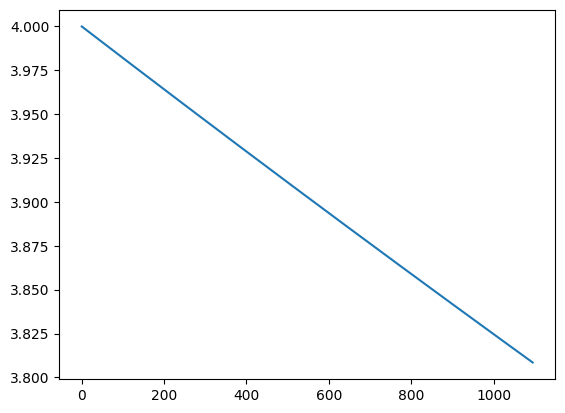

In [25]:
plt.plot(capacities)

In [26]:
import csv
f = open('test1.csv','w+',newline='')
writer = csv.writer(f)
#writer.writerow([1])
m3=[]
for x in m3_arr:
    m3 += [x for i in range(48)]

for i in range(n*48):

    writer.writerow([m1_arr[i],m2_arr[i],m3[i],power_Arr[i]])
    #writer.writerow([m2_arr[i]])
    #writer.writerow([m3[i]])

f.close()
    #writer.writerow(x)